In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [10]:
df = pd.read_csv('sms-spam-collection-dataset/spam.csv', encoding = 'latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [11]:
df.rename(columns = {'v1': 'label', 'v2': 'message'}, inplace = True)
df.label.replace(to_replace=['ham', 'spam'], value=[0, 1], inplace=True)
df.head()

,label,message,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,0,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,0,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,0,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,0,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [13]:
arr, indexes = np.unique(df[:]['message'],return_index=True)
df_uniq = df.iloc[indexes,:]
df_uniq.head()

,label,message,Unnamed: 2,Unnamed: 3,Unnamed: 4
4024,0,&lt;#&gt; in mca. But not conform.,NaN,NaN,NaN
3014,0,&lt;#&gt; mins but i had to stop somewhere f...,NaN,NaN,NaN
4264,0,&lt;DECIMAL&gt; m but its not a common car he...,NaN,NaN,NaN
2765,0,and picking them up from various points,NaN,NaN,NaN
3671,0,"came to look at the flat, seems ok, in his 50...",NaN,NaN,NaN


In [14]:
def clean_text(message):
    dummy = message.replace("&gt","").replace("&lt","").lower()
    clean = ''.join(ch for ch in dummy if ch.isalnum() or ch == ' ')
    return clean.strip()

In [15]:
X = df_uniq['message'].values
for i, message in enumerate(X):
    X[i] = clean_text(message)

y = df_uniq['label'].values

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print(len(X_train))
print(len(X_test))

3618
1551


In [17]:
class SpamClassifier(object):
    
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def train(self):
        self.get_words_spam_ham()
        self.get_prob_words_spam_ham()

    def calc_prob_spam_ham(self):  # Calculates P(ham) and P(spam)
        c1 = len(self.y[self.y == 0])
        c2 = len(self.y[self.y == 1])
    
        p1 = c1 / (c1 + c2)
        p2 = c2 / (c1 + c2)

        return p1,p2
    
    def extract_words(self, msg):       # Extracts words from a sentence
        words = []
        for word in msg.split():
            if word not in words:
                words.append(word)
        return words
    
    def get_words_spam_ham(self):     # Gets count of all words present in spam and ham emails differently
        self.ham_words = {}
        self.spam_words = {}
        for i,msg in enumerate(X):
            if y[i] == 0:
                for word in msg.split():
                    if word not in self.ham_words:
                        self.ham_words[word] = 1
                    else:
                        self.ham_words[word] += 1    
            else:
                for word in msg.split():
                    if word not in self.spam_words:
                        self.spam_words[word] = 1
                    else:
                        self.spam_words[word] += 1
    
    def get_prob_words_spam_ham(self): # Calculates P(wi|spam) and P(wi|ham) for every word wi
        
        # Probability of word being ham, from list of words in ham
        self.word_ham_prob = {}
        for k,v in self.ham_words.items():
            if k in self.spam_words:
                self.word_ham_prob[k] = v / (self.spam_words[k] + v)
            else:
                self.word_ham_prob[k] = 1
        
        # Proabability of word being spam, from list of words in spam
        self.word_spam_prob = {}
        for k,v in self.spam_words.items():
            if k in self.ham_words:
                self.word_spam_prob[k] = v / (self.ham_words[k] + v)
            else:
                self.word_spam_prob[k] = 1
        # print(self.word_ham_prob)
        # print(self.word_spam_prob)
    
    def classify(self,msg):
        words = self.extract_words(msg)
        prob_h = 1
        prob_s = 1
        p_ham, p_spam = self.calc_prob_spam_ham()
        
        for word in words:
            if word in self.word_spam_prob:
                prob_s *= self.word_spam_prob[word]
            else:                 # For a new word assume p = 0.5
                prob_s *= 0.5
        pSpam = prob_s * p_spam
        
        for word in words:
            if word in self.word_ham_prob:
                prob_h *= self.word_ham_prob[word]
            else:                 # For a new word assume p = 0.5
                prob_h *= 0.5
        pHam = prob_h * p_ham
        
        return pSpam >= pHam
    
    def predict(self, testData):
        result = []
        for (i, message) in enumerate(testData):
            processed_message = clean_text(message)
            result.append(int(self.classify(processed_message)))
        
        return result

In [26]:
def metrics(labels, predictions):
    true_pos, true_neg, false_pos, false_neg = 0, 0, 0, 0
    for i in range(len(labels)):
        true_pos += int(labels[i] == 1 and predictions[i] == 1)
        true_neg += int(labels[i] == 0 and predictions[i] == 0)
        false_pos += int(labels[i] == 0 and predictions[i] == 1)
        false_neg += int(labels[i] == 1 and predictions[i] == 0)
    precision = true_pos / (true_pos + false_pos)
    recall = true_pos / (true_pos + false_neg)
    Fscore = 2 * precision * recall / (precision + recall)
    accuracy = (true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg)

    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F-score: ", Fscore)
    print("Accuracy: ", accuracy)

In [19]:
sc = SpamClassifier(X_train,y_train)
sc.train()
y_pred = sc.predict(X_test)
metrics(y_test,y_pred)

Precision:  1.0
Recall:  0.44549763033175355
F-score:  0.6163934426229508
Accuracy:  0.9245647969052224


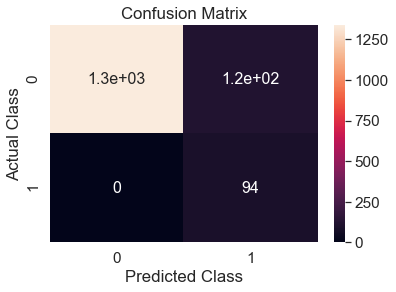

In [20]:
# Function to plot Confusion Matrix
def plot_confusion_matrix(Y_pred,Y):
    cm = confusion_matrix(Y_pred, Y, labels=None, sample_weight=None)
    
    df_cm = pd.DataFrame(cm, range(2), range(2))
    sns.set(font_scale = 1.4) #for label size
    ax = sns.heatmap(df_cm, annot = True, annot_kws = {"size": 16})
    ax.set_title("Confusion Matrix")
    ax.set(xlabel = 'Predicted Class', ylabel = 'Actual Class')
    plt.show()

plot_confusion_matrix(y_pred,y_test)

In [35]:
z = input()
sc.predict([z])

soft computing assignment


[0]

In [32]:
X_test

array(['i donno its in your genes or something', 'how are you i miss you',
       'maybe if you woke up before fucking 3 this wouldnt be a problem',
       ...,
       'im in inperialmusic listening2the weirdest track ever byåóleafcutter johnåósounds like insects being molestedsomeone plumbingremixed by evil men on acid',
       'are you the cutest girl in the world or what',
       'you call him and tell now infront of them call him now'],
      dtype=object)